# 8.1 Introduction to convolutional neural networks (convnets)

In [6]:
# instantiating a small convnet

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1)) # (image_height, image_width, image_channels)

# number of channels passed as the first argument to the Conv2D layers
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          11,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

Last Conv2D layer outputs shape (3, 3, 128): a 3 x 3 feature map of 128 channels.

To feed this rank-3 tensor into a Dense layer in the next step, we apply the `Flatten` layers before adding the `Dense` layer to convert these tensors into vectors.

In [8]:
# training the convnet on MNIST images

from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - accuracy: 0.8856 - loss: 0.3566
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 77s 60ms/step - accuracy: 0.9853 - loss: 0.0487
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.9905 - loss: 0.0316
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.9934 - loss: 0.0216
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.9945 - loss: 0.0160


In [9]:
# evaluate the model on the test set

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test accuracy: {test_acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9876 - loss: 0.0393
test accuracy: 0.991


We went from a 97.8% accuracy to 99.3% accuracy using a basic convnet. Decreased the error rate by about 60% (relative).

Why does this work so well?

## 8.1.1 The convolution operation

Fundamental difference: `Dense` layers learn global patterns in their input feature space (for MNIST digit, patters involving all pixels). Whereas convolutional layers learn local patterns—in image case, patterns found in small 2D windows of the inputs.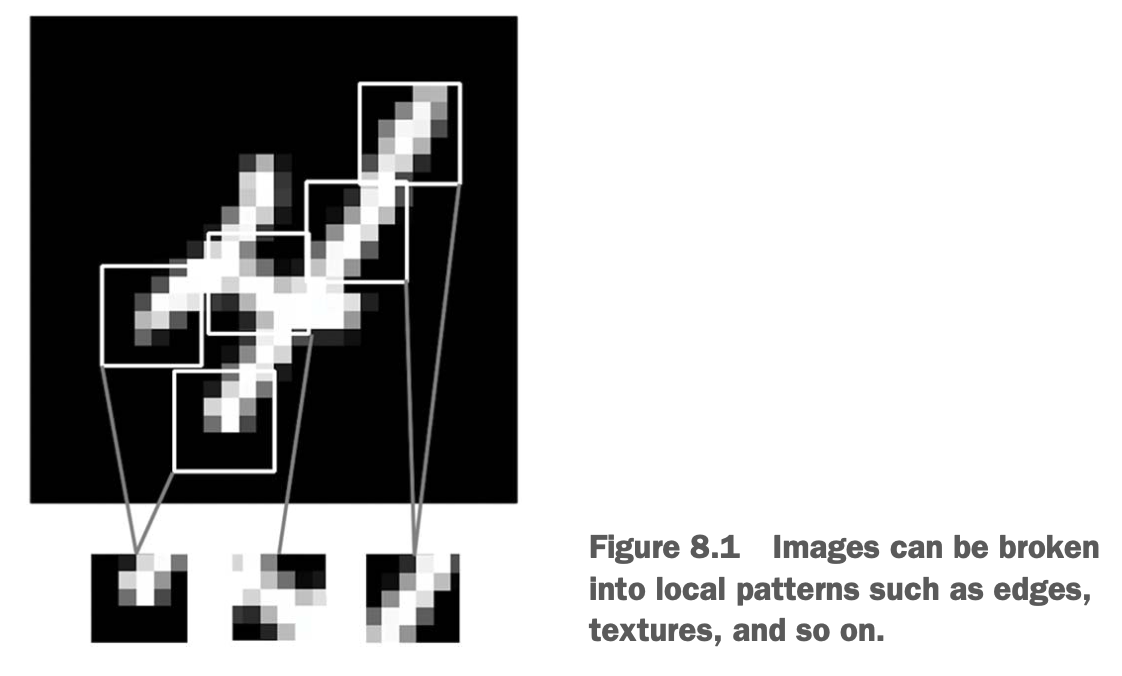

Two key properties of convnets:
1. *Patterns they learn are translation invariant*: if they learn a pattern in the lower left corner, they will recognize it in the lower right corner or anywhere else. *Visual world is fundamentally translation-invariant*.
2. *They learn spatial hierarchies of patterns*: 1st conv layer will learn small local patterns like edges, second will learn larger patterns made of features of the last layer, and so on. *Visual world is fundamentally spatially hierarchical*/

- Convolutions operate over rank-3 tensors called *feature maps*: 2 spatial axes and 1 *depth* (or *channels*) axis.
  - For RGB, it's 3, for grayscale, it's 1.
- Convolution operation acts on input feature map and extracts patches and applied the same transform^n to all these patches, producing an *output feature map*.

- The depth of the outputs stand for *filter*: filters encode specific aspects of the input data: at a high level, a single filter could encode the concept "presence of a face" etc.
- In our example, the 1st convo layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): computes 32 filters over its input.
  - Each of these 32 channels contain 26x26 grid of values—a *response map* of the filter over the input.


Convolutions are defined by 2 key params:
- *Size of the patches extracted from input*: usually 3x3 or 5x5.
- *Depth of the output feature map*: number of filters computed by the convolution.



In [10]:
# Convnet without the max-pooling layers

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
#x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │         619,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 712,202 (2.72 MB)

 Trainable params: 712,202 (2.72 MB)

 Non-trainable params: 0 (0.00 B)